# Preprocessing

Mounting to drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing required packages

In [5]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pickle
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import train_test_split
from google.colab import files
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import random

In [ ]:
# Reading original data
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/lastfm-dataset-1K.tar/lastfm-dataset-1K/lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv',sep="\t", on_bad_lines='skip')
# Renaming the columns
data.columns =['userid', 'timestamp', 'artist_id', 'artist_name', 'track_id', 'track_name']
# Dropping rows where track id or track name is null
data['track_name'].isnull().values.any()
data=data.dropna(subset=['track_name'])

data['track_id'].isnull().values.any()
data=data.dropna(subset=['track_id'])
# resetting the index
data.reset_index(drop=True)

In [ ]:
# Convert object type to datetime object
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['timestamp'] = pd.to_datetime(data['timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S.%f"))
print(data.dtypes)


Unnamed: 0              int64
userid                 object
timestamp      datetime64[ns]
artist_id              object
artist_name            object
track_id               object
track_name             object
dtype: object


In [ ]:
data.shape

(16936134, 7)

Creating Sessions

In [ ]:

# Sort the data by user and timestamp to ensure sequential order
data=data.groupby(['userid']).apply(lambda x: x.sort_values(['timestamp'], ascending=True)).reset_index(drop=True)

# Function to create unique session IDs based on time difference
def create_session_ids(data, threshold_time):
    session_ids = []
    prev_user = None
    prev_timestamp = None
    session_id_counter = 0

    for index, row in data.iterrows():
        user_id = row['userid']
        timestamp = pd.to_datetime(row['timestamp'])

        if prev_user is None or user_id != prev_user or (timestamp - prev_timestamp).total_seconds() > threshold_time:
            # Start a new session for a different user or if the time difference exceeds the threshold
            session_id_counter += 1

        session_ids.append(session_id_counter)

        prev_user = user_id
        prev_timestamp = timestamp

    return session_ids

# Set the threshold time in seconds (Here, 360 seconds = 6 minutes)
threshold_time_seconds = 360





In [ ]:
# Create unique session IDs based on the time difference
data['session_id'] = create_session_ids(data, threshold_time_seconds)

In [ ]:
data.head(-100)

,userid,timestamp,artist_id,artist_name,track_id,track_name,session_id
0,user_1,2006-08-13 13:59:20,09a114d9-7723-4e14-b524-379697f6d2b5,Plaid & Bob Jaroc,c4633ab1-e715-477f-8685-afa5f2058e42,The Launching Of Big Face,1
1,user_1,2006-08-13 14:03:29,09a114d9-7723-4e14-b524-379697f6d2b5,Plaid & Bob Jaroc,bc2765af-208c-44c5-b3b0-cf597a646660,Zn Zero,1
2,user_1,2006-08-13 14:10:43,09a114d9-7723-4e14-b524-379697f6d2b5,Plaid & Bob Jaroc,aa9c5a80-5cbe-42aa-a966-eb3cfa37d832,The Return Of Super Barrio - End Credits,2
3,user_1,2006-08-13 14:17:40,67fb65b5-6589-47f0-9371-8a40eb268dfb,Tommy Guerrero,d9b1c1da-7e47-4f97-a135-77260f2f559d,Mission Flats,3
4,user_1,2006-08-13 14:19:06,1cfbc7d1-299c-46e6-ba4c-1facb84ba435,Artful Dodger,120bb01c-03e4-465f-94a0-dce5e9fac711,What You Gonna Do?,3
...,...,...,...,...,...,...,...
16936029,user_999,2009-05-02 09:21:16,b7ffd2af-418f-4be2-bdd1-22f8b48613da,Nine Inch Nails,f68d3318-e0b8-4612-b95b-9710e6ddd322,The Day The World Went Away,3671979
16936030,user_999,2009-05-02 09:26:34,ff4308de-5b17-4869-ad77-ea41d8bf3b18,Henry Homesweet,68fa3259-dbc2-4cb4-9fe1-326bc248f856,Pocket Monster,3671979
16936031,user_999,2009-05-02 09:28:13,b7ffd2af-418f-4be2-bdd1-22f8b48613da,Nine Inch Nails,3fffc4ec-6cf0-4e4c-b1e5-5c988f07bf3e,24 Ghosts Iii,3671979
16936032,user_999,2009-05-02 09:31:17,c27f8fae-e697-4959-a791-babfd0a4ecbf,"Raz, Dwa, Trzy",6a9ab649-5de2-4adf-a798-4fdd30805e08,Czarna Inez,3671979


In [ ]:
data.to_csv('/content/drive/MyDrive/Colab Notebooks/Project/clean_data.csv',index=False)

In [ ]:
data.shape

(16936134, 7)

In [6]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/clean_data.csv', on_bad_lines='skip',index_col=False)

Creating Tagged document

In [ ]:
def create_tagged_document(data):
    tagged_data = []
    words=[]
    session_id=1
    for idx, row in data.iterrows():
      if row['session_id'] == session_id:
        words.append(row['track_id'])
      else:
        tagged_data.append(TaggedDocument(words=words, tags=[str(session_id)]))
        words=[]
        words.append(row['track_id'])
        session_id=row['session_id']
    return tagged_data

tagged_data = create_tagged_document(data)

#Save the tagged document for future use
with open('/content/drive/MyDrive/Colab Notebooks/Project/tagged_documents.pkl', 'wb') as f:
    pickle.dump(tagged_data, f)



In [ ]:
tagged_data[-1]

TaggedDocument(words=['0143a8e6-b63d-441b-aae1-44e48a633140', '6e27866c-07a1-425d-bb4f-9d9e728db344', '039f3379-3a69-4e75-a882-df1c4e1608aa', 'f68d3318-e0b8-4612-b95b-9710e6ddd322', '3fffc4ec-6cf0-4e4c-b1e5-5c988f07bf3e', '1da70975-2cbe-49e8-abc1-3fba89e26dc3', 'bcd98fd0-05f3-4fe9-b76d-a10470bdb0a7'], tags=['3671998'])

In [ ]:
# Split data into train and test sets
train_data, test_data = train_test_split(tagged_data, test_size=0.6, random_state=42)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Project/train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)
with open('/content/drive/MyDrive/Colab Notebooks/Project/test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)


In [7]:
with open('/content/drive/MyDrive/Colab Notebooks/Project/train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/Project/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [8]:
# Split test into validation and test sets
val_data, testing_data = train_test_split(test_data, test_size=0.8, random_state=42)

Graph creation using song similarity

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Project/doc2vec_win_5_epoch_50.pkl', 'rb') as file:
    model1 = pickle.load(file)

In [6]:
all_songs=[]
for tagged_data in train_data:
        songs = tagged_data.words
        for song in songs:
          all_songs.append(song)
unique_songs=list(set(all_songs))

print(len(unique_songs))

719509


In [11]:
# Create a directed graph
G = nx.DiGraph()

# Function to add sessions as directed edges in the graph
def create_graph(graph, data):
    for song in unique_songs:
      try:
        simsongs=model1.wv.most_similar(song,topn=20)
        for song_id,sim_score in simsongs:
          if sim_score>=0.5:
            source_node = song
            target_node = song_id
            graph.add_edge(source_node, target_node,weight=sim_score)
      except KeyError:
        pass

# Add sessions to the graph
create_graph(G, train_data)


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Project/graph.pkl', 'wb') as f:
    pickle.dump(G, f)

In [35]:
with open('/content/drive/MyDrive/Colab Notebooks/Project/graph.pkl', 'rb') as f:
    G = pickle.load(f)

In [30]:
d = dict(songid_song)
print(d)

{'0894dc79-b001-48dd-b69a-ad436a9175c6': 'Suburbia', '83c775e3-4548-4743-9b61-34e1fbdb044d': 'Hellig Krig På Jagtvej', 'e55f6a7a-d856-47bd-93f4-ee0bf3768ee2': 'Live My Life Resisting', 'e2e2d165-8a63-455d-9d1b-82682a9862ed': 'Conformity', 'a6558a3a-ca56-449f-9619-4c218e1e8479': 'Mischief Night', '46e1baa5-ab81-44a1-bd65-e4a1948e72eb': 'Fred Gennem Overlegen Ildkraft', '4fbcf2c9-a9b2-404d-98e3-696cf2e70160': 'American Justice Is All A Lie', '3665551c-f280-4077-9bc6-56ef17c54027': 'Old People Talk Loud', '2b3770ac-313c-40f5-8ee4-035d3d96eee5': 'To Minutters Stilhed', '560f9398-7269-4bcb-98e8-5e180869d38f': 'Fjender', '73e72026-b72a-422e-a0ac-61dfd75ba430': 'Consume', '226ee4cd-55b9-4b2f-ae5b-ba390803f3f7': 'Idealets Pris', 'e4227395-1fad-4322-8912-e1348d20e8c0': 'Together We Shout', 'c6a97123-71a6-4287-bc8e-5ca40725dbf0': 'Danskhed', 'a24f3e16-b123-464b-8ad0-fb2764cb32c4': 'Finding Freedom In Hopelessness', 'd41677e7-f5b1-4df7-b9bf-4183bf8000e4': 'Ikke En Chance', 'c0a9eaec-6713-404c-872

In [45]:
len((G.nodes()))

240553

Graph analysis

In [23]:
if nx.is_weakly_connected(G):
  print("Yes graph is weakly connected")
else: print(nx.number_weakly_connected_components(G))

2


In [11]:
weak_components=list(nx.weakly_connected_components(G))
component_sizes = [len(component) for component in weak_components]

print(component_sizes)


[240529, 24]


In [ ]:
#min(weak_components, key=len)
subgraph = G.subgraph(min(weak_components, key=len))
songid_song=[]
for i in list(subgraph.nodes()):
  song_name=data[data['track_id']==i]['track_name'].tolist()[0]
  songid_song.append((i,song_name))
d = dict(songid_song)
G_renamed = nx.relabel_nodes(subgraph, d)
subgraph_renamed = nx.relabel_nodes(subgraph, d)
# Plot the subgraph
pos = nx.spring_layout(subgraph_renamed, seed=42)  # For layout positioning
nx.draw(subgraph_renamed, pos, with_labels=True, node_size=30, node_color='yellow', font_size=7, font_color='gray',edge_color='gray',width=0.1,arrowsize=3)
plt.title("Smallest weak component Visualization")
plt.show()


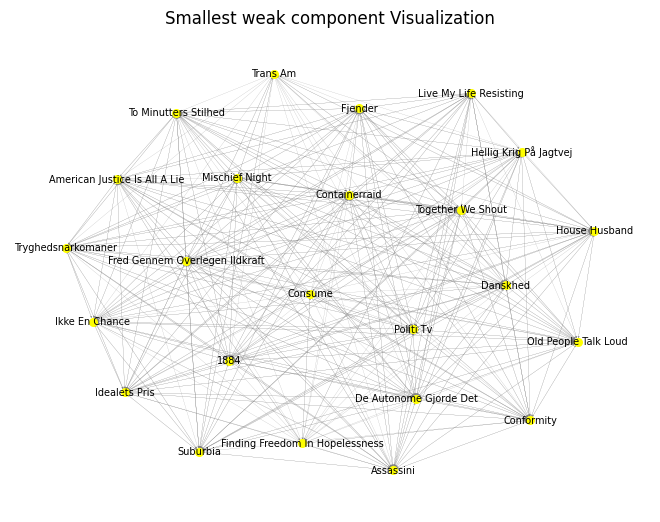

In [15]:
# Plot the subgraph
pos = nx.spring_layout(subgraph_renamed, seed=42)  # For layout positioning
nx.draw(subgraph_renamed, pos, with_labels=True, node_size=30, node_color='yellow', font_size=7, font_color='black',edge_color='gray',width=0.1,arrowsize=3)
plt.title("Smallest weak component Visualization")
plt.show()

In [22]:
if nx.is_strongly_connected(subgraph):
  print("Yes sub graph is strongly connected")
else: print(nx.number_strongly_connected_components(subgraph))

Yes graph is strongly connected


In [21]:
# Create a subgraph for the largest weakly connected component
strong_components=list(nx.strongly_connected_components(G))
strong_components.remove(max(strong_components, key=len))
largest_strong_subgraph = G.subgraph(max(strong_components, key=len))

# Calculate the diameter of the largest weakly connected component
diameter = nx.diameter(largest_strong_subgraph)

print("Diameter of the Second Largest Strongly Connected Component:", diameter)


Diameter of the Largest Strongly Connected Component: 14


In [23]:
diameter_nodes = []

for source_node in largest_strong_subgraph.nodes():
    distances = nx.shortest_path_length(largest_strong_subgraph, source=source_node)
    max_distance_node = max(distances, key=distances.get)
    if distances[max_distance_node] == diameter:
        diameter_nodes.append((source_node, max_distance_node))

print(f"Diameter of the graph: {diameter}")
print("Nodes contributing to the diameter:")
for source_node, max_distance_node in diameter_nodes:
    print(f"({source_node}, {max_distance_node})")
# Find the shortest path
shortest_path = nx.shortest_path(G, source=source_node, target=max_distance_node)

print(f"Shortest path between Node {source_node} and Node {max_distance_node}: {shortest_path}")

Diameter of the graph: 14
Nodes contributing to the diameter:
(409da0f6-2e1a-4d69-893a-cfa32a3152db, 8d728989-a857-4ea0-afd0-73affc18ec48)
Shortest path between Node 409da0f6-2e1a-4d69-893a-cfa32a3152db and Node 8d728989-a857-4ea0-afd0-73affc18ec48: ['409da0f6-2e1a-4d69-893a-cfa32a3152db', 'dbca08a3-0282-4231-8708-e5bbf79285c3', 'b15a4da2-2996-4331-9e24-5de019186c2a', 'ce595e65-d31d-4138-a206-5fb09f5db63d', 'b5eec268-e640-483b-9cf7-e855589b4d24', 'b912f44d-0431-4ea3-9ad5-b83b0da70b66', '7d298e10-2f0c-4e90-bad7-34154adc9f40', 'd4898a97-32ec-471c-ad77-a874ecf1f3e4', 'b18139c6-7bc4-4ce1-8b7a-f7936b318a2a', '6aaed1bf-5223-4ecd-98b5-f514195eb7c6', 'd264157f-ee1c-4dec-8b8a-6a8a5ac84d42', '16a55a36-a5d5-4a3a-acd7-7d0b85e9e539', 'e25c5afc-1383-4164-857b-9885b7acf694', '61d78bc9-a212-4299-87cb-00b1f85df12d', '8d728989-a857-4ea0-afd0-73affc18ec48']


In [24]:
songname_songartist=[]
for i in shortest_path:
  song_name=data[data['track_id']==i]['track_name'].tolist()[0]
  artist_name=data[data['track_id']==i]['artist_name'].tolist()[0]
  songname_songartist.append((song_name,artist_name))
print(songname_songartist)

[('Der Picknicker', 'Die Fantastischen Vier'), ('S.M.U.D.O. Ich Bin Halt So', 'Die Fantastischen Vier'), ('Ganz Weit Weg', 'Die Fantastischen Vier'), ('Das Interview', 'Die Fantastischen Vier'), ('Dionysos', 'Fettes Brot'), ('Wer Gibt Dem Der Unten Liegt Die Hand', 'Fettes Brot'), ('Rocky Beach Theme', 'Fettes Brot'), ('Wie Immer', 'Fettes Brot'), ("Rock Mic'S", 'Fettes Brot'), ('No Answer', 'Falco'), ('Data De Groove', 'Falco'), ('Buenos Dias Messias (A Cappella)', 'Die Fantastischen Vier'), ('45 Fieber', 'Die Fantastischen Vier'), ('Geboren', 'Die Fantastischen Vier'), ('Mikrofonprofessor', 'Die Fantastischen Vier')]


In [43]:
average_degree = sum(dict(G.degree()).values()) / len(G)

print(f"Average Degree: {average_degree:.2f}")

Average Degree: 39.83


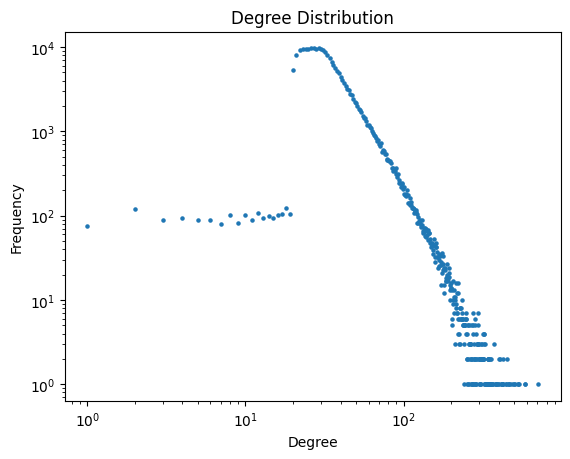

In [40]:
degree_hist = nx.degree_histogram(G)

# Plot the degree distribution
plt.scatter(range(len(degree_hist)), degree_hist,s=5)
#plt.hist(degree_hist)

plt.xscale('log')
plt.xlabel("Degree")
plt.yscale('log')
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.show()

Graph Creation using session based data


In [41]:
# Create a directed graph
G1 = nx.DiGraph()

# Function to add sessions as directed edges in the graph
def add_sessions_to_graph(graph, data):
    for tagged_data in data:
        songs = tagged_data.words
        for i in range(len(songs) - 1):
            source_node = songs[i]
            target_node = songs[i + 1]
            if graph.has_edge(source_node, target_node):
              graph[source_node][target_node]['weight'] = graph[source_node][target_node]['weight'] + 1
            else:
              graph.add_edge(source_node, target_node,weight=1)

# Add sessions to the graph
add_sessions_to_graph(G1, train_data)



Graph analysis

If graph is weakly connected else Number of weakly connected components

In [11]:
if nx.is_weakly_connected(G1):
  print("Yes graph is weakly connected")
else: print(nx.number_weakly_connected_components(G1))

12256


In [12]:
average_degree = sum(dict(G1.degree()).values()) / len(G)

print(f"Average Degree: {average_degree:.2f}")

Average Degree: 16.13


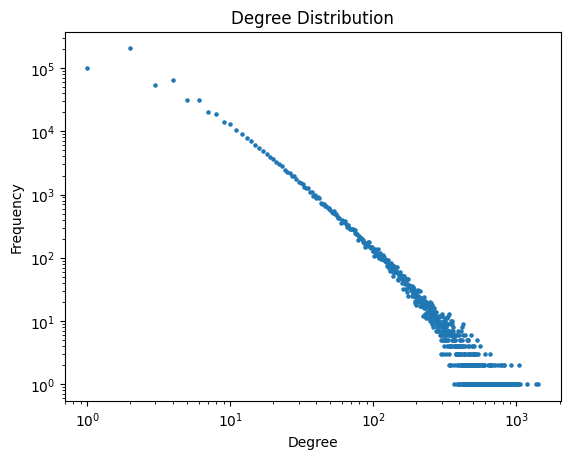

In [42]:
degree_hist = nx.degree_histogram(G1)

# Plot the degree distribution
plt.scatter(range(len(degree_hist)), degree_hist,s=5)
#plt.hist(degree_hist)

plt.xscale('log')
plt.xlabel("Degree")
plt.yscale('log')
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.show()

In [ ]:
weak_components=list(nx.weakly_connected_components(G))
component_sizes = [len(component) for component in weak_components]

# Plot the size distribution
plt.bar(range(len(component_sizes)),component_sizes )
plt.xlabel("Component Size")
plt.ylabel("Frequency")
plt.title("Weakly Connected Component Size Distribution")
#plt.xticks(range(1, max(component_sizes)+1))
plt.show()

In [44]:
len(G1.nodes())

681850

In [18]:
len(weak_components[0])

240529

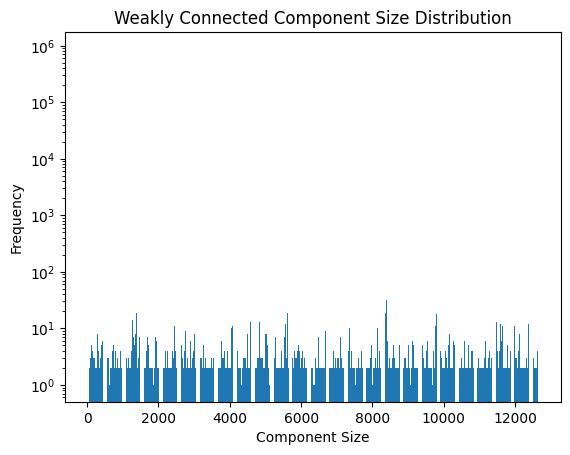

In [13]:
weak_components=list(nx.weakly_connected_components(G))
component_sizes = [len(component) for component in weak_components]

# Plot the size distribution
plt.bar(range(len(component_sizes)),component_sizes,log=True )
plt.xlabel("Component Size")
plt.ylabel("Frequency")
plt.title("Weakly Connected Component Size Distribution")
#plt.xticks(range(1, max(component_sizes)+1))
plt.show()


In [10]:
avg_cluster_coefficient = nx.average_clustering(G)

print(f"Average Clustering Coefficient: {avg_cluster_coefficient:.4f}")

Average Clustering Coefficient: 0.0211


In [49]:
weak_components = list(nx.weakly_connected_components(G))
clu=[]
# Calculate and plot the average clustering coefficient for each component
for component in weak_components:
    subgraph = G.subgraph(component)
    avg_clustering = nx.average_clustering(subgraph)
    length_of_component=len(component)
    #print(f"Component: {component}, Average Clustering Coefficient: {avg_clustering:.4f}")
    clu.append((length_of_component,avg_clustering))


In [50]:
clu

[(240529, 0.23181247700083477), (24, 0.916119837026227)]

In [47]:
clu_0_0point2=[]
clu_0point2_0point4=[]
clu_0point4_0point6=[]
clu_0point6_0point8=[]
clu_0point8_above=[]
for i in range(0,len(clu)):
  if clu[i]<=0.2:
    clu_0_0point2.append(clu[i])
  elif 0.2<clu[i]<=0.4:
    clu_0point2_0point4.append(clu[i])
  elif 0.4<clu[i]<=0.6:
    clu_0point4_0point6.append(clu[i])
  elif 0.6<clu[i]<=0.8:
    clu_0point6_0point8.append(clu[i])
  elif clu[i]>0.8:
    clu_0point8_above.append(clu[i])

print(len(clu_0_0point2))
print(len(clu_0point2_0point4))
print(len(clu_0point4_0point6))
print(len(clu_0point6_0point8))
print(len(clu_0point8_above))

0
1
0
0
1


In [51]:
def get_test_session(test_data,index):
  if len(test_data[index][0])<3:
    print("Choose some other test session as this one is too small to suggest next song.")
    return (0,0,0)
  else:
    next_song_id=test_data[index][0][-1]
    next_song=data[data['track_id']==next_song_id]['track_name'].tolist()[0]
    next_artist=data[data['track_id']==next_song_id]['artist_name'].tolist()[0]
    session=test_data[index][0][:-1]
    return session,next_song,next_artist


In [57]:
def recommend_top_songs_graph(graph,session,personalization_factor,alpha,max_iter):

  if personalization_factor==0:
      ppr = nx.pagerank(graph,alpha=alpha,max_iter=max_iter)
  else:
    try:
      personalization=dict.fromkeys(G.nodes(),0)
      mytuple=(personalization_factor/len(session))
      res=((mytuple,)*len(session))
      personalization.update(dict(zip(session, res)))
      ppr = nx.pagerank(graph,personalization=personalization,alpha=alpha,max_iter=max_iter,weight='weight')
    except ZeroDivisionError:
      ppr = nx.pagerank(graph,alpha=alpha,max_iter=max_iter)
      pass
    sorted_nodes = sorted(ppr.items(), key=lambda x: x[1], reverse=True)
    top_n=10
    recommend_songs = [data[data['track_id']==node]['track_name'].tolist()[0] for node, score in sorted_nodes[:top_n]]
    recommend_artist = [data[data['track_id']==node]['artist_name'].tolist()[0] for node, score in sorted_nodes[:top_n]]
    score=[score for node, score in sorted_nodes[:top_n]]
  return recommend_songs,recommend_artist



def hit_rate_graph(test_data,pf=1,alpha=0.85,max_iter=50):
    total_sessions = len(test_data)
    correct_recommendations = 0
    actual_total_sessions=0
    for i in range(0,total_sessions):
      session,actual_next_song,actual_next_artist=get_test_session(test_data,i)
      if (session,actual_next_song,actual_next_artist)==(0,0,0):
        continue
      else:
        recommended_songs,recommended_artist = recommend_top_songs_graph(G,session,pf,alpha,max_iter)
        if recommended_songs==[]:
          print("Page rank did not recommend songs for the given sequence.")
        else:
          actual_total_sessions=actual_total_sessions+1
          print("recommended songs",recommended_songs)
          print("actual song",actual_next_song)
          print("recommended artists",recommended_artist)
          print("actual artist",actual_next_artist)
          if actual_next_song in recommended_songs:
            correct_recommendations += 1
          elif actual_next_artist in recommended_artist:
            correct_recommendations += 0.5


    hit_rate = correct_recommendations / actual_total_sessions
    print(actual_total_sessions)
    return hit_rate

In [53]:
def MRR_graph(test_data,pf=1,alpha=0.85,max_iter=50):
    total_sessions = len(test_data)
    sum_reciprocal_rank = 0
    actual_total_sessions=0
    for i in range(0,total_sessions):
      session,actual_next_song,actual_next_artist=get_test_session(test_data,i)
      if (session,actual_next_song,actual_next_artist)==(0,0,0):
        continue
      else:
        actual_total_sessions=actual_total_sessions+1
        recommended_songs,recommended_artist = recommend_top_songs_graph(G,session,pf,alpha,max_iter)
        print("recommended songs",recommended_songs)
        print("actual song",actual_next_song)
        print("recommended artists",recommended_artist)
        print("actual artist",actual_next_artist)
        if actual_next_song in recommended_songs:
          rank = recommended_songs.index(actual_next_song)+1 #because we start from 0 index
          print(rank)
          sum_reciprocal_rank += 1.0/rank
          print(sum_reciprocal_rank)


    mrr = sum_reciprocal_rank / actual_total_sessions
    print(actual_total_sessions)
    return mrr

In [ ]:
hit_rate_graph(val_data[:21],pf=0)

Choose some other test session as this one is too small to suggest next song.
0
recommended songs ['Love Will Tear Us Apart', 'Such Great Heights', 'Teardrop', 'Neighborhood #1 (Tunnels)', 'Crazy', 'Karma Police', 'Soul Meets Body', 'Come As You Are', '1979', 'I Will Follow You Into The Dark']
actual song The Ocean
recommended artists ['Boy Division', 'The Postal Service', 'Massive Attack', 'Arcade Fire', 'Gnarls Barkley', 'Radiohead', 'Death Cab For Cutie', 'Nirvana', 'The Smashing Pumpkins', 'Death Cab For Cutie']
actual artist Ambulance Ltd
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
0
recommended songs ['Love Will Tear Us Apart', 'Such Great Heights', 'Teardrop', 'Neighborhood #1 (Tunnels)', 'Crazy', 'Karma Police', 'Soul Meets Body', 'Come As You Are', '1979', 'I Will Follow You Into The Dark']
actual song Mellowship Slinky In B Major
recommended artists ['Boy Division',

0.0

In [ ]:
hit_rate_graph(val_data[:21],pf=1)

Choose some other test session as this one is too small to suggest next song.
(0.25, 0.25, 0.25, 0.25)
[0.05438135308505104, 0.047561767621896484, 0.04756043238158492, 0.04756016815762517, 0.016725457653418492, 0.013000802918261077, 0.005968431470028927, 0.00529854677332994, 0.004499525188715892, 0.0044973699107713275]
recommended songs ['All Along The Watchtower', 'Tales', 'Sunset Superman', 'Rough House Blues', 'Love Train', "Devil'S Eyes", 'The Good Life', 'Forever Young', 'One Chance', 'Runaway']
actual song The Ocean
recommended artists ['Bob Dylan', 'Wolfmother', 'Dio', 'Buck 65', 'Wolfmother', 'Buck 65', 'Weezer', 'Bob Dylan', 'Modest Mouse', 'Bon Jovi']
actual artist Ambulance Ltd
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
(0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666)
[0.0426754698425232

0.4444444444444444

In [59]:
hit_rate_graph(val_data[:21],pf=1,alpha=0.3)

Choose some other test session as this one is too small to suggest next song.
recommended songs ['Sunset Superman', 'All Along The Watchtower', 'Rough House Blues', 'Tales', 'Big Bad Bill (Is Sweet William Now)', 'Where Have All The Good Times Gone?', 'Hold My Beer', 'Say Hello', 'Encarnación', 'Dirty Movies']
actual song The Ocean
recommended artists ['Dio', 'Bob Dylan', 'Buck 65', 'Wolfmother', 'Van Halen', 'Van Halen', 'Aaron Pritchett', 'April Wine', 'Jack Black', 'Van Halen']
actual artist Ambulance Ltd
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
recommended songs ['Suck My Kiss', 'If You Have To Ask', 'Breaking The Girl', 'I Could Have Lied', 'Funky Monks', "They'Re Red Hot", 'I Could Die For You', "Rock 'N' Roll Radio", 'One Hot Minute', 'Drop Your Guns']
actual song Mellowship Slinky In B Major
recommended artists ['Red Hot Chili Peppers', 'Red Hot Chili Peppers', 'Re

0.3888888888888889

In [60]:
hit_rate_graph(val_data[:21],pf=1,alpha=1)

Choose some other test session as this one is too small to suggest next song.
recommended songs ['Gonna Be (Video Mix)', 'Modern Things', 'Science Fiction Jazz (Ultra Short Cut)', 'Bad Luck (Feat. Joseph Malik)', "Theme From Abbadesse'S Street", 'Chop! Chop! (Feat. Esham)', 'Stop To Make A Change', 'Blast', 'Moments Of Your Time', 'Better Days (Feat. Varano & Tiger Lily)']
actual song The Ocean
recommended artists ["Mo' Horizons", 'Björk', 'Minus 8', 'Trüby Trio', 'Soulstance', 'Insane Clown Posse', 'Nostalgia 77', 'Boozoo Bajou', 'Vitor Joaquim', 'Stéphane Pompougnac']
actual artist Ambulance Ltd
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
recommended songs ['Gonna Be (Video Mix)', 'Modern Things', 'Science Fiction Jazz (Ultra Short Cut)', 'Bad Luck (Feat. Joseph Malik)', "Theme From Abbadesse'S Street", 'Chop! Chop! (Feat. Esham)', 'Stop To Make A Change', 'Blast', 'Moments

0.0

Final Testing

In [ ]:
hit_rate_graph(testing_data[:150])

Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
1
{'bbfd8451-6f0f-4c05-860e-33793c4a6a88': 1, '73b95e51-3235-46ca-a403-0c25637a31fc': 1}
[0.09693198440632066, 0.09538138053886602, 0.007608692941281966, 0.0076045803210069525, 0.007604388698078536, 0.007602297155443565, 0.007602023458554859, 0.007601463613175292, 0.007600486826981467, 0.007600437052156506]
recommended songs ['Things That Scare Me', 'Revolver', 'This S*It Will Fcuk You Up', 'Like You', 'Sleeping Awake', 'Was It A Dream', 'La Morte Degli Amanti', 'Boogie 2Nite (Seamus Haji Big Love Remix)', 'Keys To The City', 'Berta Filava']
actual song Pass The Marijuana
recommended artists ['Neko Case', 'Baustelle', 'Combichrist', 'Evanescence', 'P.O.D.', '30 Seconds To Mars', 'Le Vene Di Lucretia', 'Booty Luv', 'The Go! Team', 'Rino Gaetano']
actual artist Mystic Roots
Choose some other test session as this one is too small to su

0.3157894736842105

In [ ]:
MRR_graph(testing_data[:150])

Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
[0.09693198440632066, 0.09538138053886602, 0.007608692941281966, 0.0076045803210069525, 0.007604388698078536, 0.007602297155443565, 0.007602023458554859, 0.007601463613175292, 0.007600486826981467, 0.007600437052156506]
recommended songs ['Things That Scare Me', 'Revolver', 'This S*It Will Fcuk You Up', 'Like You', 'Sleeping Awake', 'Was It A Dream', 'La Morte Degli Amanti', 'Boogie 2Nite (Seamus Haji Big Love Remix)', 'Keys To The City', 'Berta Filava']
actual song Pass The Marijuana
recommended artists ['Neko Case', 'Baustelle', 'Combichrist', 'Evanescence', 'P.O.D.', '30 Seconds To Mars', 'Le Vene Di Lucretia', 'Booty Luv', 'The Go! Team', 'Rino Gaetano']
actual artist Mystic Roots
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next 

0.02739139515455305

In [61]:
hit_rate_graph(testing_data[:150])

Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
recommended songs ['Revolver', 'Things That Scare Me', 'Ciao Ciao', 'Tu Lo Sai', 'Babbaluci', "Le Guardie, I Pompieri E L'Ambulanza", 'Caffè Nero Bollente', 'Arriva Lo Ye-Ye', 'Pretty Girls', 'Guided By Wire']
actual song Pass The Marijuana
recommended artists ['Baustelle', 'Neko Case', 'Colle Der Fomento', 'Bassi Maestro', 'Roy Paci & Aretuska', 'Cor Veleno', 'Fiorella Mannoia', 'Baustelle', 'Neko Case', 'Neko Case']
actual artist Mystic Roots
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
Choos

0.24342105263157895

In [62]:
MRR_graph(testing_data[:150])

Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
recommended songs ['Revolver', 'Things That Scare Me', 'Ciao Ciao', 'Tu Lo Sai', 'Babbaluci', "Le Guardie, I Pompieri E L'Ambulanza", 'Caffè Nero Bollente', 'Arriva Lo Ye-Ye', 'Pretty Girls', 'Guided By Wire']
actual song Pass The Marijuana
recommended artists ['Baustelle', 'Neko Case', 'Colle Der Fomento', 'Bassi Maestro', 'Roy Paci & Aretuska', 'Cor Veleno', 'Fiorella Mannoia', 'Baustelle', 'Neko Case', 'Neko Case']
actual artist Mystic Roots
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
Choos

0.010484544695071011